Hi, so using the methods developed here I was able to download a large dataset of two kinds of images: 1. Shaded relief map tiles of seabed with at least one seamount on it  2. Shaded relief map tiles of seabed without seamounts. With this dataset (that at the moment is 2500 images with seamounts and 1000 without, but could be extended to about 10000 images each) I would like to build a simple neural network with the aim to be able to take on the binary classification task of deciding whether there is a seamount in the image when presented with a new map tile. My first task is to build a baseline model for that, can you assist me?

In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Parameters
image_folder = "./data_241208"  # Root directory of the dataset
output_folder = "temp_processed_data_241208"  # Temporary folder for cropped images
image_size = (128, 128)  # Image dimensions for the model
crop_pixels = 70  # Pixels to crop from each border
batch_size = 32
epochs = 15

# Categories
categories = ["with_seamount_manual1", "without_seamounts_manual1"]  # Subfolders in `image_folder`

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to crop borders from an image
def crop_fixed_border(image, crop_pixels=5):
    height, width, _ = image.shape
    if height > crop_pixels * 2 and width > crop_pixels * 2:
        cropped_image = image[crop_pixels:height-crop_pixels, crop_pixels:width-crop_pixels]
        return cropped_image
    else:
        return image  # Return original image if cropping not possible

# Preprocess images (cropping and resizing)
print("Preprocessing images...")
for category in categories:
    category_folder = os.path.join(image_folder, category)
    output_category_folder = os.path.join(output_folder, category)
    os.makedirs(output_category_folder, exist_ok=True)
    
    for file_name in os.listdir(category_folder):
        image_path = os.path.join(category_folder, file_name)
        output_path = os.path.join(output_category_folder, file_name)
        try:
            image = cv2.imread(image_path)
            if image is not None:
                cropped_image = crop_fixed_border(image, crop_pixels)
                resized_image = cv2.resize(cropped_image, image_size)
                cv2.imwrite(output_path, resized_image)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Preprocessing complete.")

# Load processed dataset
def load_data(directory, categories):
    data, labels = [], []
    for label, category in enumerate(categories):
        category_folder = os.path.join(directory, category)
        for file_name in os.listdir(category_folder):
            file_path = os.path.join(category_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                data.append(image)
                labels.append(label)
    return np.array(data), np.array(labels)

data, labels = load_data(output_folder, categories)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Preprocessing images...
Preprocessing complete.


In [2]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print(classification_report(y_test, y_pred, target_names=categories))

# Save the model
model.save("seamount_classifier_baseline_with_cropping.h5")
print("Model saved.")


Epoch 1/15
14/14 [==============================] - 4s 47ms/step - loss: 0.8078 - accuracy: 0.4738 - val_loss: 0.6953 - val_accuracy: 0.4444
Epoch 2/15
14/14 [==============================] - 0s 20ms/step - loss: 0.6921 - accuracy: 0.5190 - val_loss: 0.6813 - val_accuracy: 0.7444
Epoch 3/15
14/14 [==============================] - 0s 20ms/step - loss: 0.6987 - accuracy: 0.5238 - val_loss: 0.6953 - val_accuracy: 0.4444
Epoch 4/15
14/14 [==============================] - 0s 20ms/step - loss: 0.6969 - accuracy: 0.5190 - val_loss: 0.6789 - val_accuracy: 0.7111
Epoch 5/15
14/14 [==============================] - 0s 20ms/step - loss: 0.6738 - accuracy: 0.5738 - val_loss: 0.6003 - val_accuracy: 0.6778
Epoch 6/15
14/14 [==============================] - 0s 19ms/step - loss: 0.6491 - accuracy: 0.6452 - val_loss: 0.4678 - val_accuracy: 0.8556
Epoch 7/15
14/14 [==============================] - 0s 20ms/step - loss: 0.5464 - accuracy: 0.7357 - val_loss: 0.5047 - val_accuracy: 0.7556
Epoch 8/15
14

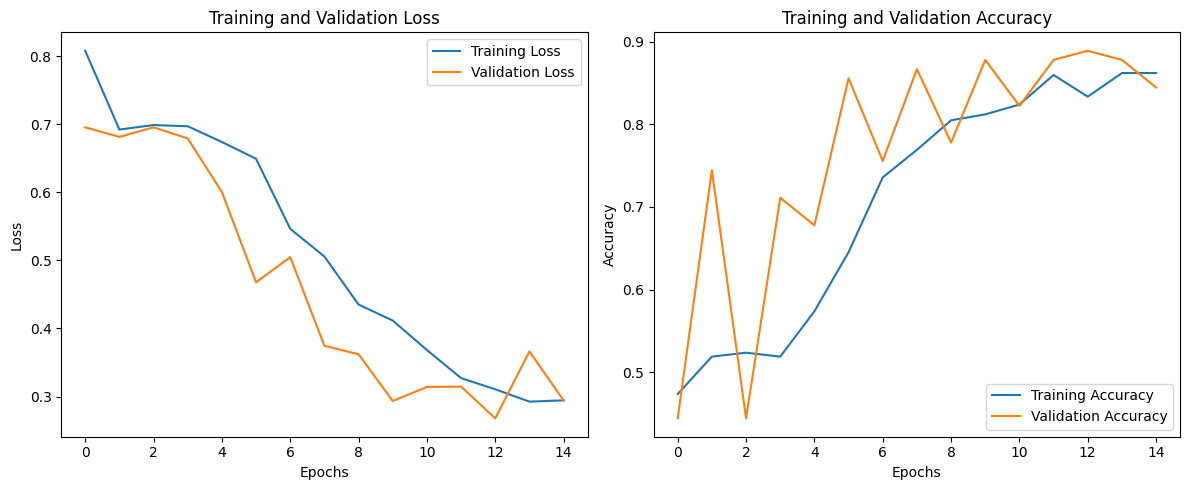

3/3 [==============================] - 0s 7ms/step


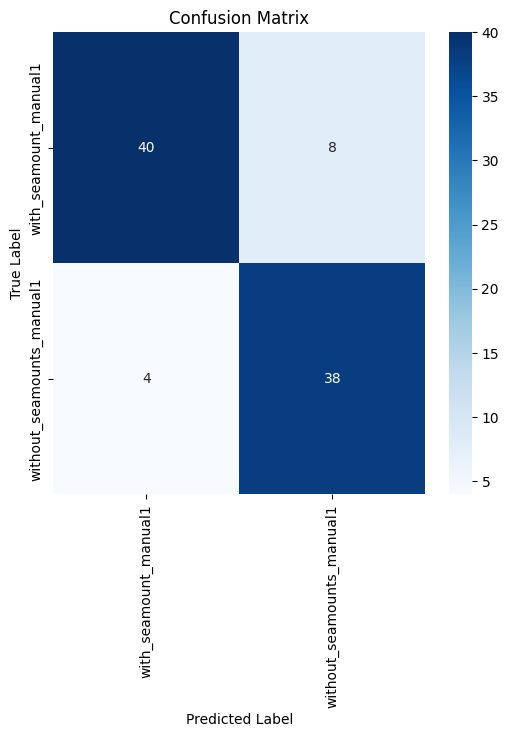

3/3 [==============================] - 0s 7ms/step


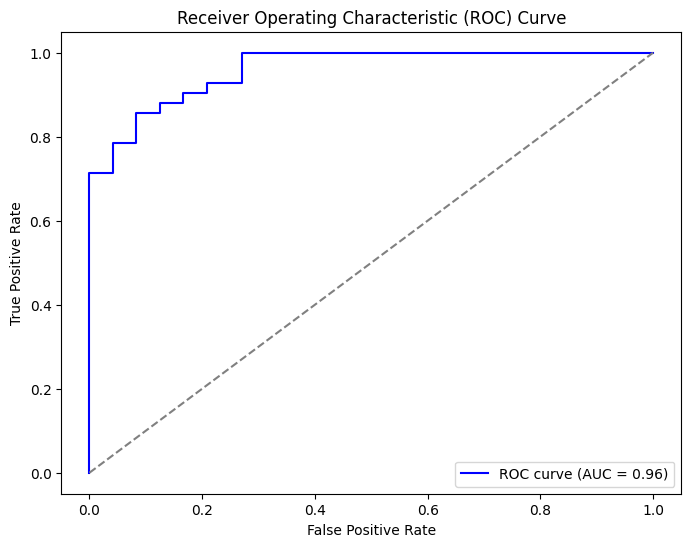

3/3 [==============================] - 0s 8ms/step
Classification Report:
                           precision    recall  f1-score   support

    with_seamount_manual1       0.91      0.83      0.87        48
without_seamounts_manual1       0.83      0.90      0.86        42

                 accuracy                           0.87        90
                macro avg       0.87      0.87      0.87        90
             weighted avg       0.87      0.87      0.87        90

Precision: 0.83
Recall: 0.90
F1 Score: 0.86


In [3]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Plotting the training/validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Compute confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test).flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Displaying 8 False Negative images


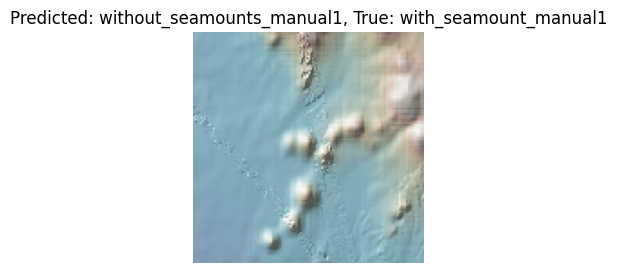

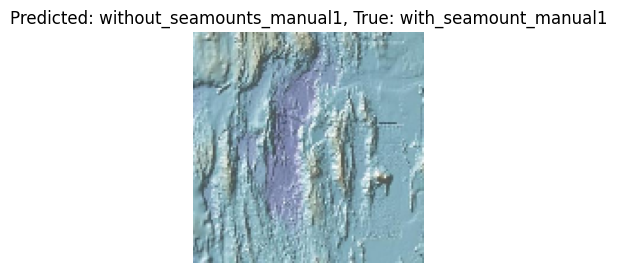

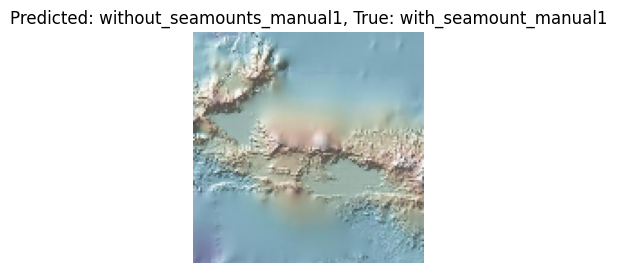

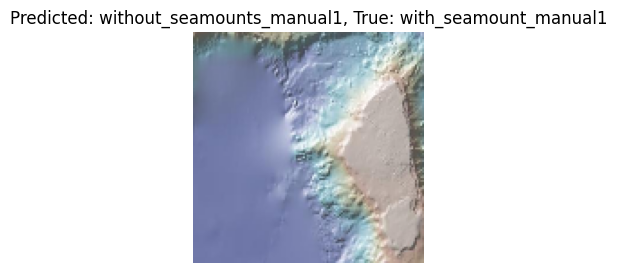

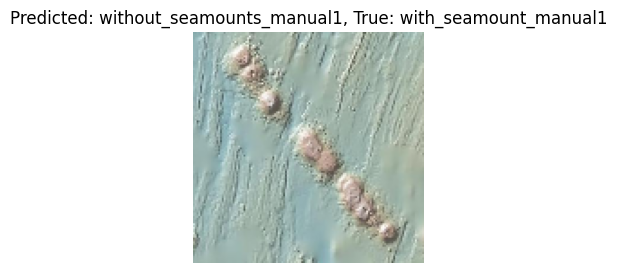

Displaying 4 False Positive images


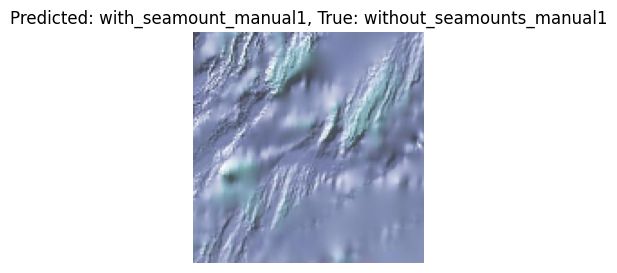

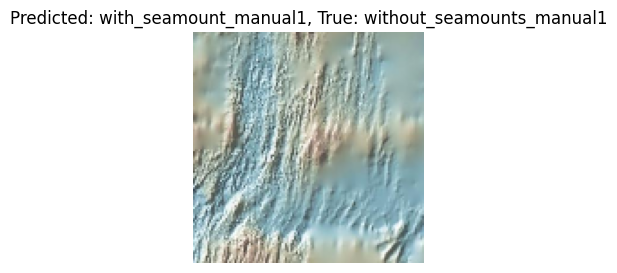

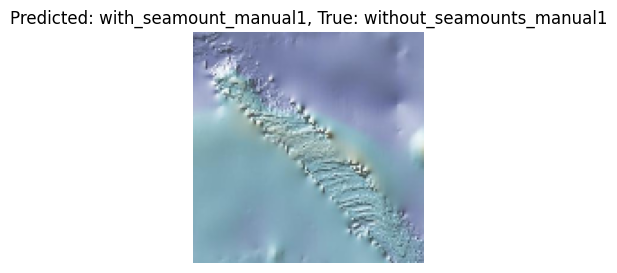

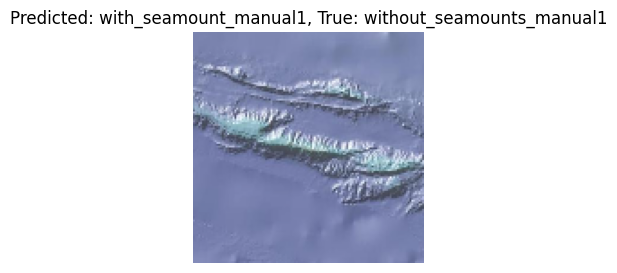

In [8]:
import matplotlib.pyplot as plt
import cv2

# Get the indices of false positives and false negatives
false_positives = []
false_negatives = []

# Loop through the test set to find false positives and false negatives
for i in range(len(y_test)):
    if y_pred[i] == 1 and y_test[i] == 0:  # Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)
        false_positives.append(i)
    elif y_pred[i] == 0 and y_test[i] == 1:  # Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative)
        false_negatives.append(i)

# Display false positives
print(f"Displaying {len(false_positives)} False Negative images")
for i in range(min(5, len(false_positives))):  # Show up to 5 false positives
    index = false_positives[i]
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {categories[1]}, True: {categories[0]}")
    plt.axis('off')
    plt.show()

# Display false negatives
print(f"Displaying {len(false_negatives)} False Positive images")
for i in range(min(5, len(false_negatives))):  # Show up to 5 false negatives
    index = false_negatives[i]
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {categories[0]}, True: {categories[1]}")
    plt.axis('off')
    plt.show()
